<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/main/2D_Pore_Reaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.7/190.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.1 MB/s eta 0:00:00


Compiling model...
Building feed-forward neural network...
'build' took 0.179974 s

'compile' took 1.711698 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.70e-01, 2.65e-01]    [1.91e-01, 2.65e-01]    []  
1000      [1.28e-06, 7.22e-08]    [9.23e-07, 7.22e-08]    []  
2000      [2.13e-07, 1.72e-08]    [1.50e-07, 1.72e-08]    []  
3000      [4.78e-08, 1.44e-08]    [3.98e-08, 1.44e-08]    []  
4000      [7.02e-08, 2.94e-07]    [5.86e-08, 2.94e-07]    []  
5000      [1.73e-08, 1.27e-08]    [1.58e-08, 1.27e-08]    []  
6000      [1.24e-08, 8.53e-09]    [1.12e-08, 8.53e-09]    []  
7000      [8.68e-09, 5.98e-09]    [7.57e-09, 5.98e-09]    []  
8000      [3.78e-09, 3.01e-09]    [3.20e-09, 3.01e-09]    []  
9000      [2.18e-09, 1.64e-09]    [2.00e-09, 1.64e-09]    []  
10000     [2.45e-09, 9.09e-10]    [2.79e-09, 9.09e-10]    []  

Best model at step 10000:
  train loss: 3.36e-09
  test loss: 3.70e-09
  test metric: []

'train' took 23.

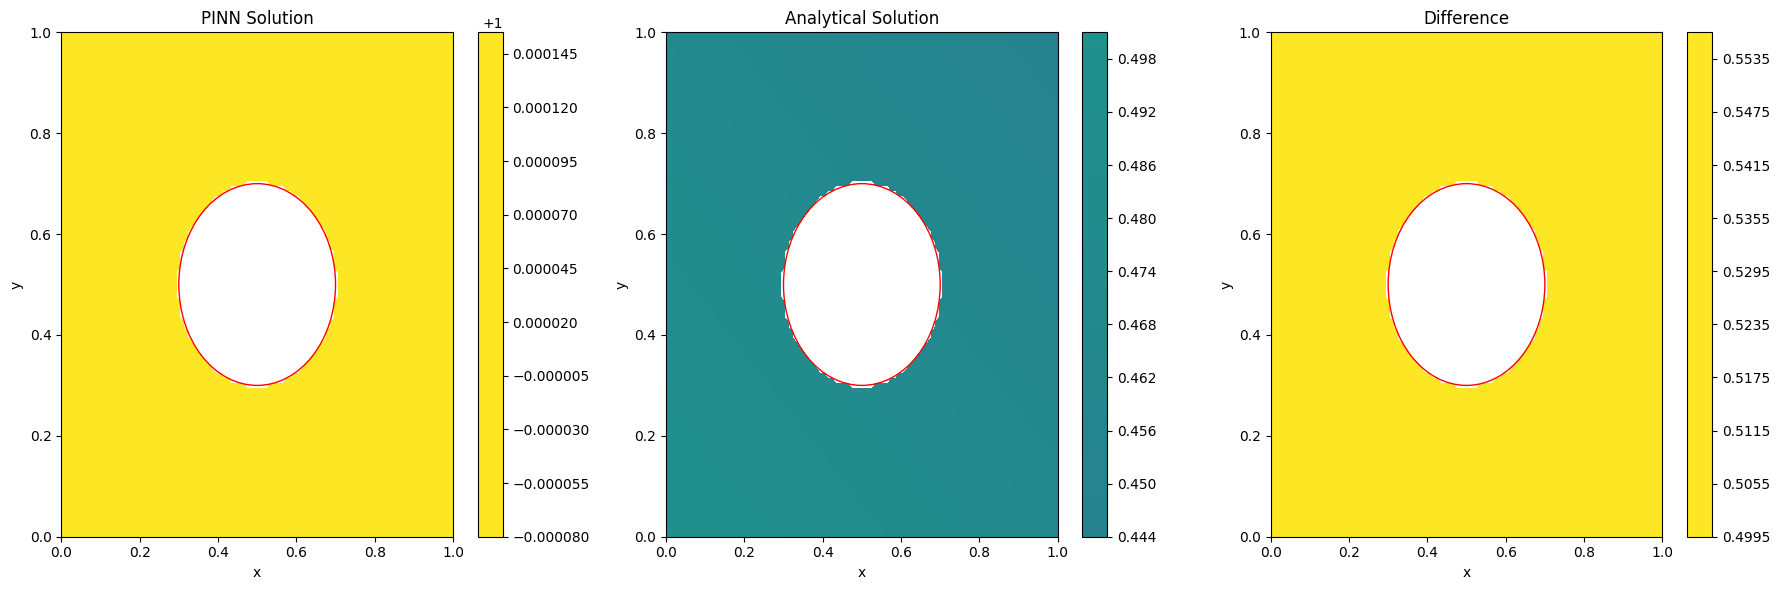

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


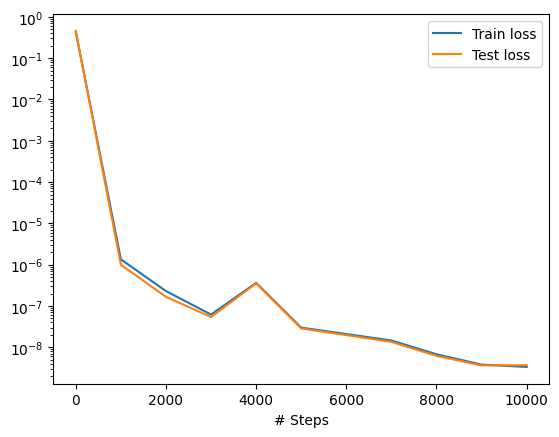

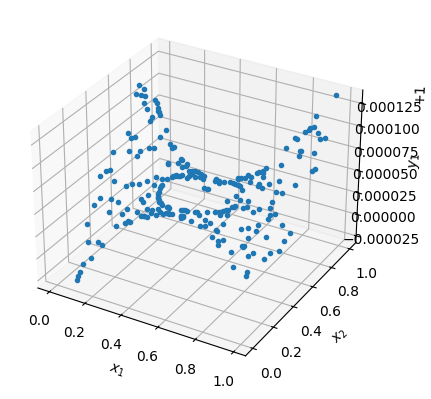

In [5]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Original PINN parameters
D = 1.0
k = 0.1
alpha = 1.0
u0 = 0.5  # Added from your visualization code

# Original geometry setup
outer = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])
inclusion = dde.geometry.Disk(center=[0.5, 0.5], radius=0.2)
fluid_domain = outer - inclusion

# Original boundary condition
def robin_func(x, u):
    return k * (alpha - u)

def boundary_solid(x, on_boundary):
    return on_boundary and inclusion.on_boundary(x)

robin_bc = dde.icbc.RobinBC(fluid_domain, robin_func, boundary_solid)

# Original PDE definition
def pde(x, u):
    d2u_dx2 = dde.grad.hessian(u, x, i=0, j=0)
    d2u_dy2 = dde.grad.hessian(u, x, i=1, j=1)
    return D * (d2u_dx2 + d2u_dy2)

# Original training setup
data = dde.data.PDE(
    fluid_domain,
    pde,
    [robin_bc],
    num_domain=1000,
    num_boundary=100,
    num_test=200,
)

net = dde.nn.FNN([2] + [50] * 4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=10000)

# Enhanced visualization with proper 2D contour plots
def create_contour_plots(model):
    # Create grid covering the entire domain
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x, y)
    grid = np.vstack([X.flatten(), Y.flatten()]).T

    # Filter points inside actual domain
    valid_points = fluid_domain.inside(grid)

    # Get PINN predictions
    pinn_pred = np.full(grid.shape[0], np.nan)
    pinn_pred[valid_points] = model.predict(grid[valid_points]).flatten()
    Z_pinn = pinn_pred.reshape(X.shape)

    # Analytical solution (2D adaptation of your 1D solution)
    def analytical_2d(x, y):
        r = np.sqrt((x-0.5)**2 + (y-0.5)**2)
        valid = r > 0.2  # Exclude circular region
        return np.where(valid, u0 + (k*(alpha - u0)/(k*1.0 - D))*(x+y)/2, np.nan)

    Z_analytic = analytical_2d(X, Y)
    difference = Z_pinn - Z_analytic

    # Create figure with 3 subplots
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Plot configurations
    titles = ['PINN Solution', 'Analytical Solution', 'Difference']
    data = [Z_pinn, Z_analytic, difference]
    clim = [0, 1]  # Shared color limits for solutions

    for i, (axi, title, dat) in enumerate(zip(ax, titles, data)):
        # Contour plot with 50 levels
        cont = axi.contourf(X, Y, dat, levels=50, cmap='viridis',
                          vmin=clim[0] if i < 2 else -0.01,
                          vmax=clim[1] if i < 2 else 0.01)

        # Add circular boundary
        circle = plt.Circle((0.5, 0.5), 0.2, color='red', fill=False)
        axi.add_patch(circle)

        axi.set_title(title)
        axi.set_xlabel('x')
        axi.set_ylabel('y')
        plt.colorbar(cont, ax=axi)

    plt.tight_layout()
    plt.show()

# Generate and display plots
create_contour_plots(model)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


Compiling model...
Building feed-forward neural network...
'build' took 0.112663 s

'compile' took 1.012498 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.70e-01, 2.31e-01]    [1.85e-01, 2.31e-01]    []  
1000      [9.81e-07, 6.44e-08]    [7.56e-07, 6.44e-08]    []  
2000      [1.56e-07, 2.07e-08]    [1.23e-07, 2.07e-08]    []  
3000      [4.40e-08, 1.69e-08]    [2.99e-08, 1.69e-08]    []  
4000      [3.77e-07, 2.43e-06]    [3.88e-07, 2.43e-06]    []  
5000      [1.89e-08, 1.24e-08]    [1.17e-08, 1.24e-08]    []  
6000      [1.24e-08, 7.99e-09]    [7.74e-09, 7.99e-09]    []  
7000      [8.63e-09, 4.53e-09]    [5.75e-09, 4.53e-09]    []  
8000      [2.14e-08, 2.96e-08]    [1.47e-08, 2.96e-08]    []  
9000      [5.80e-09, 2.07e-09]    [4.10e-09, 2.07e-09]    []  
10000     [1.44e-09, 6.30e-10]    [1.10e-09, 6.30e-10]    []  

Best model at step 10000:
  train loss: 2.07e-09
  test loss: 1.73e-09
  test metric: []

'train' took 18.

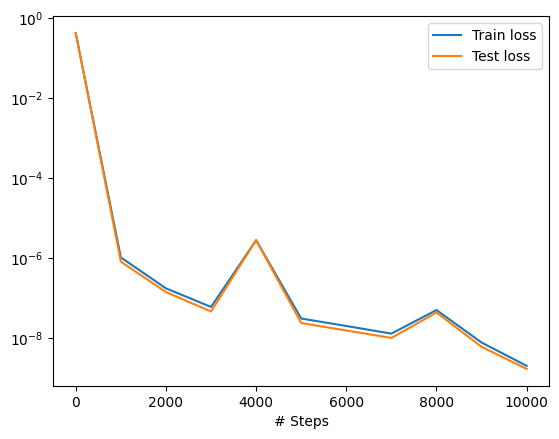

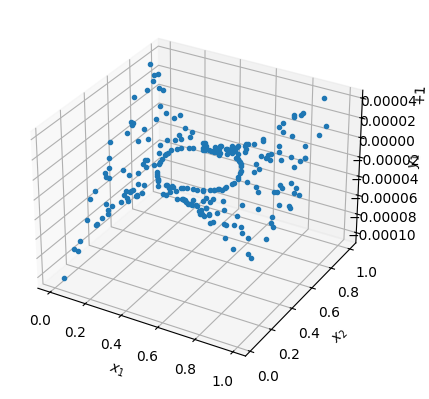

In [4]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Original PINN setup (preserved exactly)
D = 1.0
k = 0.1
alpha = 1.0
u0 = 0.5


outer = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])
inclusion = dde.geometry.Disk(center=[0.5, 0.5], radius=0.2)
fluid_domain = outer - inclusion

def robin_func(x, u):
    return k * (alpha - u)

def boundary_solid(x, on_boundary):
    return on_boundary and inclusion.on_boundary(x)

robin_bc = dde.icbc.RobinBC(
    fluid_domain,
    robin_func,
    boundary_solid
)

def pde(x, u):
    d2u_dx2 = dde.grad.hessian(u, x, i=0, j=0)
    d2u_dy2 = dde.grad.hessian(u, x, i=1, j=1)
    return D * (d2u_dx2 + d2u_dy2)

data = dde.data.PDE(
    fluid_domain,
    pde,
    [robin_bc],
    num_domain=1000,
    num_boundary=100,
    num_test=200,
)

net = dde.nn.FNN([2] + [50] * 4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=10000)

# Modified visualization section (new code)
def create_visualization(model):
    # Generate 2D grid points
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x, y)
    grid = np.vstack([X.flatten(), Y.flatten()]).T

    # Filter points outside domain
    valid_points = fluid_domain.inside(grid)
    grid_valid = grid[valid_points]

    # Get predictions
    pinn_pred = model.predict(grid_valid)

    # Create full grid arrays
    Z_pinn = np.full(X.shape, np.nan)
    Z_pinn[valid_points.reshape(X.shape)] = pinn_pred.flatten()

    # Analytical solution (modified for 2D comparison)

def analytical_2d(x, y):
    r = np.sqrt((x-0.5)**2 + (y-0.5)**2)
    return np.where(r > 0.2, alpha - (alpha - u0)*np.exp(-k*r/D), np.nan)


    Z_analytic = analytical_2d(X, Y)

    # Difference calculation
    difference = Z_pinn - Z_analytic

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    titles = ['PINN Solution', 'Analytical Solution', 'Difference']
    data = [Z_pinn, Z_analytic, difference]

    for ax, title, dat in zip(axes, titles, data):
        cont = ax.contourf(X, Y, dat, levels=50, cmap='viridis')
        ax.set_title(title)
        ax.set_xlabel('x'), ax.set_ylabel('y')
        fig.colorbar(cont, ax=ax)

        # Draw circular boundary
        circle = plt.Circle((0.5, 0.5), 0.2, color='red', fill=False)
        ax.add_patch(circle)

    plt.tight_layout()
    plt.show()

create_visualization(model)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Compiling model...
Building feed-forward neural network...
'build' took 0.638049 s

'compile' took 5.078788 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.72e-01, 2.16e-01]    [1.98e-01, 2.16e-01]    []  
1000      [8.74e-07, 7.07e-08]    [6.44e-07, 7.07e-08]    []  
2000      [1.49e-07, 2.54e-08]    [1.16e-07, 2.54e-08]    []  
3000      [4.42e-08, 1.56e-08]    [3.87e-08, 1.56e-08]    []  
4000      [2.44e-08, 1.45e-08]    [2.15e-08, 1.45e-08]    []  
5000      [3.24e-08, 7.89e-08]    [2.98e-08, 7.89e-08]    []  
6000      [1.19e-08, 6.77e-09]    [1.13e-08, 6.77e-09]    []  
7000      [1.39e-08, 9.73e-09]    [1.34e-08, 9.73e-09]    []  
8000      [3.33e-09, 2.

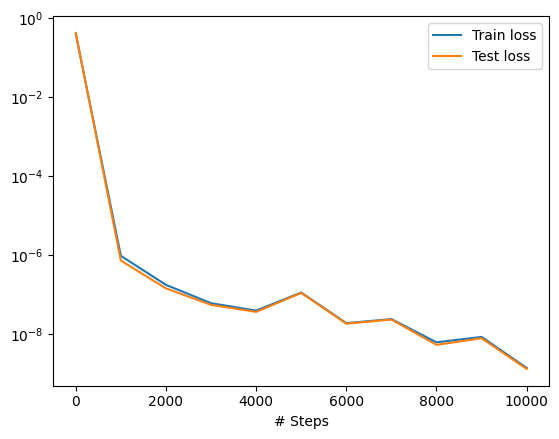

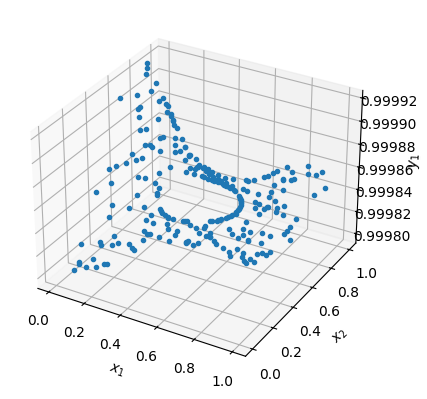

In [2]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

D = 1.0
k = 0.1
alpha = 1.0

outer = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])
inclusion = dde.geometry.Disk(center=[0.5, 0.5], radius=0.2)
fluid_domain = outer - inclusion

def robin_func(x, u):
    return k * (alpha - u)

def boundary_solid(x, on_boundary):
    return on_boundary and inclusion.on_boundary(x)

robin_bc = dde.icbc.RobinBC(
    fluid_domain,
    func=robin_func,
    on_boundary=boundary_solid
)


def pde(x, u):
    d2u_dx2 = dde.grad.hessian(u, x, i=0, j=0)
    d2u_dy2 = dde.grad.hessian(u, x, i=1, j=1)
    return D * (d2u_dx2 + d2u_dy2)  # grad^2(u) = 0

data = dde.data.PDE(
    fluid_domain,
    pde,
    [robin_bc],
    num_domain=1000,
    num_boundary=100,
    solution=None,
    num_test=200,
)

net = dde.nn.FNN(
    [2] + [50] * 4 + [1],
    "tanh",
    "Glorot normal",
)

# 5. Model Compilation
model = dde.Model(data, net)
model.compile("adam", lr=0.001)


losshistory, train_state = model.train(
    iterations=10000,
)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

#Newer

In [ ]:

import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
D = 1.0
k = 0.1
L = 2.0
r = L/4
square = dde.geometry.Rectangle([0, 0], [L, L])
pore = dde.geometry.Disk([L/2, L/2], r)
geom = dde.geometry.CSG([square], [pore])
def pde(x, u):
    u_xx = dde.grad.hessian(u, x, i=0, j=0)
    u_yy = dde.grad.hessian(u, x, i=1, j=1)
    return -D*(u_xx + u_yy) + k*u
def outer_boundary(x, on_boundary):
    if on_boundary:
        if np.isclose(x[0], 0) or np.isclose(x[0], L) or np.isclose(x[1], 0) or np.isclose(x[1], L):
            return True
    return False
def inner_boundary(x, on_boundary):
    if on_boundary:
        return np.isclose(np.sqrt((x[0]-L/2)**2+(x[1]-L/2)**2), r, atol=1e-3)
    return False
bc_outer = dde.DirichletBC(geom, lambda x: np.sin(np.pi*x[0]/L)*np.sin(np.pi*x[1]/L), outer_boundary)
bc_inner = dde.DirichletBC(geom, lambda x: 0.0, inner_boundary)
data = dde.data.PDE(geom, pde, [bc_outer, bc_inner], num_domain=4000, num_boundary=2000, num_test=1000)
net = dde.nn.FNN([2] + [50]*3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=5000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
N = 41
x_vals = np.linspace(0, L, N)
y_vals = np.linspace(0, L, N)
xx, yy = np.meshgrid(x_vals, y_vals)
xx_flat = xx.flatten()
yy_flat = yy.flatten()
boundary_mask = (np.isclose(xx_flat, 0) | np.isclose(xx_flat, L) | np.isclose(yy_flat, 0) | np.isclose(yy_flat, L))
pore_mask = ((xx_flat - L/2)**2 + (yy_flat - L/2)**2 <= r**2)
unknown_mask = ~(boundary_mask | pore_mask)
unknown_indices = np.where(unknown_mask)[0]
index_map = {idx: i for i, idx in enumerate(unknown_indices)}
h = L/(N-1)
M = len(unknown_indices)
A = lil_matrix((M, M))
b = np.zeros(M)
for idx in unknown_indices:
    i = idx // N
    j = idx % N
    p = index_map[idx]
    A[p, p] = 4*D/h**2 + k
    for di, dj in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
        i2 = i + di
        j2 = j + dj
        idx2 = i2 * N + j2
        if 0 <= i2 < N and 0 <= j2 < N:
            if unknown_mask[idx2]:
                A[p, index_map[idx2]] = -D/h**2
            else:
                x_nb = x_vals[j2]
                y_nb = y_vals[i2]
                u_nb = 0.0
                if boundary_mask[idx2]:
                    u_nb = np.sin(np.pi*x_nb/L)*np.sin(np.pi*y_nb/L)
                b[p] += D/h**2 * u_nb
u_unknown = spsolve(A.tocsr(), b)
u_fdm = np.zeros(N*N)
for idx in range(N*N):
    if unknown_mask[idx]:
        u_fdm[idx] = u_unknown[index_map[idx]]
    elif boundary_mask[idx]:
        u_fdm[idx] = np.sin(np.pi*xx_flat[idx]/L)*np.sin(np.pi*yy_flat[idx]/L)
    else:
        u_fdm[idx] = 0.0
u_fdm = u_fdm.reshape((N, N))
X_grid = np.column_stack((xx_flat, yy_flat))
u_pinn_flat = model.predict(X_grid)
u_pinn = u_pinn_flat.reshape((N, N))
diff = u_pinn - u_fdm
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.contourf(xx, yy, u_fdm, 50, cmap="viridis")
plt.title("FDM Solution")
plt.colorbar()
plt.subplot(1, 3, 2)
plt.contourf(xx, yy, u_pinn, 50, cmap="viridis")
plt.title("PINN Solution")
plt.colorbar()
plt.subplot(1, 3, 3)
plt.contourf(xx, yy, diff, 50, cmap="viridis")
plt.title("Difference")
plt.colorbar()
plt.tight_layout()
plt.show()


AttributeError: module 'deepxde.geometry' has no attribute 'CSG'

#New

Compiling model...
Building feed-forward neural network...
'build' took 0.058519 s

'compile' took 0.535646 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.58e-03, 2.50e-01, 1.34e-03]    [1.53e-03, 2.50e-01, 1.34e-03]    []  
1000      [1.58e-06, 7.57e-11, 9.13e-12]    [8.81e-07, 7.57e-11, 9.13e-12]    []  
2000      [2.13e-07, 1.03e-12, 1.66e-10]    [1.47e-07, 1.03e-12, 1.66e-10]    []  
3000      [4.45e-08, 4.30e-11, 1.16e-08]    [1.88e-08, 4.30e-11, 1.16e-08]    []  
4000      [1.03e-08, 3.20e-14, 8.53e-12]    [8.05e-09, 3.20e-14, 8.53e-12]    []  
5000      [6.82e-09, 8.88e-16, 1.90e-12]    [5.58e-09, 8.88e-16, 1.90e-12]    []  

Best model at step 5000:
  train loss: 6.82e-09
  test loss: 5.58e-09
  test metric: []

'train' took 7.566113 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


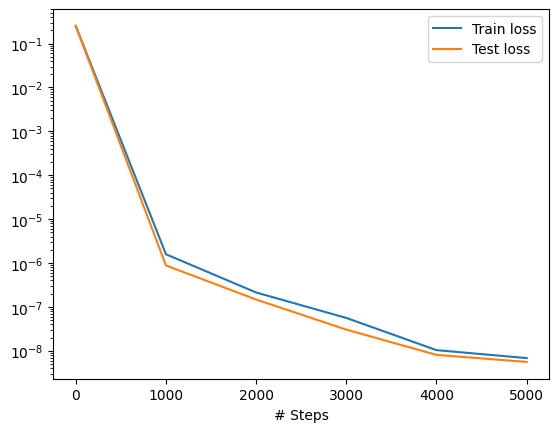

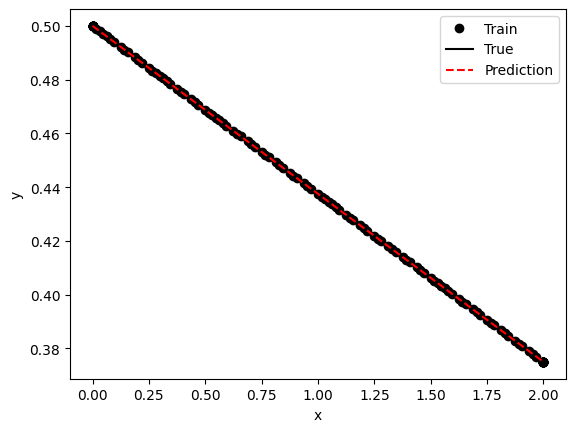

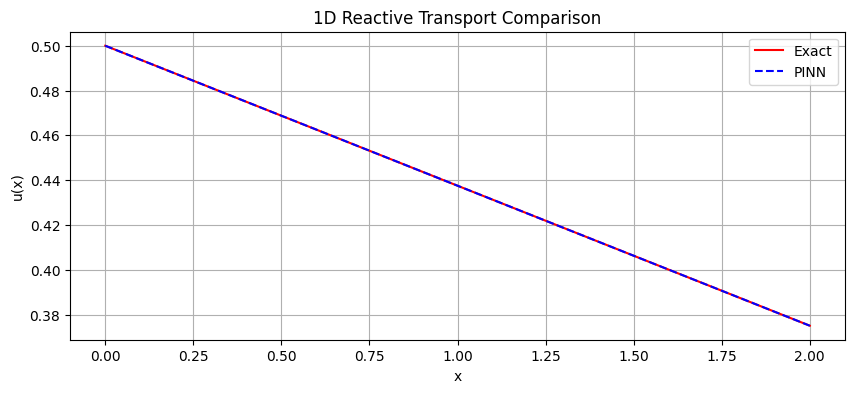

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

D = 1.0
k = 0.1
alpha = 1.0
u0 = 0.5
L = 2.0

# 1D domain
geom = dde.geometry.Interval(0, L)

def robin_func(inputs, outputs, X):
    du_dx = dde.grad.jacobian(outputs, inputs)
    return -D * du_dx - k * (alpha - outputs)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)

bc_right = dde.icbc.OperatorBC(geom, robin_func, boundary_right)


# Dirichlet BC at left boundary
bc_left = dde.icbc.DirichletBC(geom, lambda x: u0, lambda x, on_boundary: on_boundary and np.isclose(x[0], 0))

# PDE definition
def pde(x, u):
    du_xx = dde.grad.hessian(u, x)
    return D * du_xx

# Analytical solution
def exact_solution(x):
    return u0 + (k*(alpha - u0)/(k*L - D))*x

data = dde.data.PDE(
    geom,
    pde,
    [bc_left, bc_right],
    num_domain=100,
    num_boundary=20,
    solution=exact_solution,
    num_test=100,
)

net = dde.nn.FNN([1] + [50]*3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)

# Training
losshistory, train_state = model.train(iterations=5000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Plot results
x = np.linspace(0, L, 100).reshape(-1, 1)
u_pred = model.predict(x)
u_exact = exact_solution(x)

plt.figure(figsize=(10,4))
plt.plot(x, u_exact, '-r', label='Exact')
plt.plot(x, u_pred, '--b', label='PINN')
plt.xlabel('x'), plt.ylabel('u(x)')
plt.title('1D Reactive Transport Comparison')
plt.legend(), plt.grid(True)
plt.show()

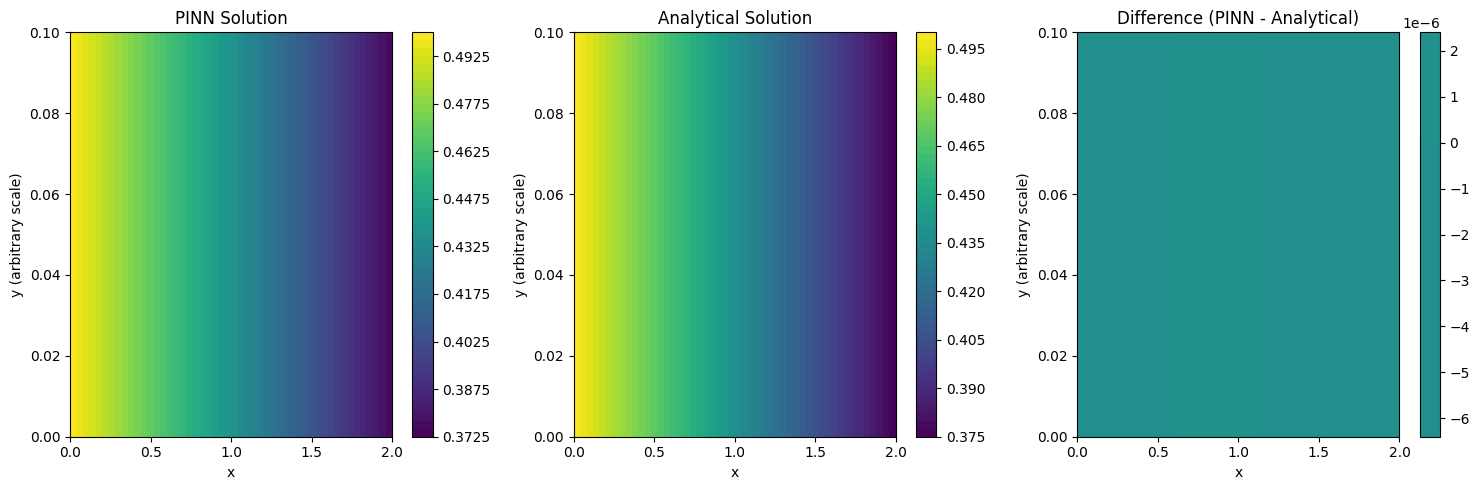

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
D = 1.0
k = 0.1
alpha = 1.0
u0 = 0.5
L = 2.0

# Generate grid points
x = np.linspace(0, L, 100)
y = np.linspace(0, 0.1, 20)
X, Y = np.meshgrid(x, y)

# Get PINN predictions (1D solution)
pinn_1d = model.predict(x.reshape(-1, 1)).flatten()  # Shape (100,)

# Analytical solution
def analytical(x):
    return u0 + (k*(alpha - u0)/(k*L - D))*x
analytic_1d = analytical(x)  # Shape (100,)

# Create 2D arrays by vertical tiling
Z_pinn_2d = np.tile(pinn_1d, (len(y), 1))  # Shape (20, 100)
Z_analytic_2d = np.tile(analytic_1d, (len(y), 1))  # Shape (20, 100)

# Calculate difference
difference = Z_pinn_2d - Z_analytic_2d

# Plotting
plt.figure(figsize=(15, 5))

# PINN Solution
plt.subplot(131)
plt.contourf(X, Y, Z_pinn_2d, levels=50, cmap='viridis')
plt.colorbar()
plt.title('PINN Solution')
plt.xlabel('x'), plt.ylabel('y (arbitrary scale)')

# Analytical Solution
plt.subplot(132)
plt.contourf(X, Y, Z_analytic_2d, levels=50, cmap='viridis')
plt.colorbar()
plt.title('Analytical Solution')
plt.xlabel('x'), plt.ylabel('y (arbitrary scale)')

# Difference Plot
plt.subplot(133)
plt.contourf(X, Y, difference, levels=50, cmap='viridis', vmin=-0.01, vmax=0.01)
plt.colorbar()
plt.title('Difference (PINN - Analytical)')
plt.xlabel('x'), plt.ylabel('y (arbitrary scale)')

plt.tight_layout()
plt.show()

#Old

Compiling model...
Building feed-forward neural network...
'build' took 0.066036 s

'compile' took 0.777705 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.37e-02, 6.54e-02]    [1.00e-02, 6.54e-02]    []  
1000      [4.88e-06, 5.56e-06]    [5.17e-06, 5.56e-06]    []  
2000      [1.91e-07, 7.32e-09]    [1.42e-07, 7.32e-09]    []  
3000      [1.22e-06, 1.97e-06]    [1.28e-06, 1.97e-06]    []  
4000      [5.65e-08, 3.13e-08]    [4.94e-08, 3.13e-08]    []  
5000      [2.78e-08, 7.47e-08]    [2.15e-08, 7.47e-08]    []  
6000      [1.69e-08, 1.27e-08]    [1.54e-08, 1.27e-08]    []  
7000      [1.97e-08, 5.24e-07]    [1.49e-08, 5.24e-07]    []  
8000      [6.78e-07, 1.74e-06]    [6.97e-07, 1.74e-06]    []  
9000      [2.50e-09, 1.14e-09]    [2.32e-09, 1.14e-09]    []  
10000     [2.20e-09, 1.36e-09]    [2.02e-09, 1.36e-09]    []  

Best model at step 10000:
  train loss: 3.56e-09
  test loss: 3.38e-09
  test metric: []

'train' took 18.

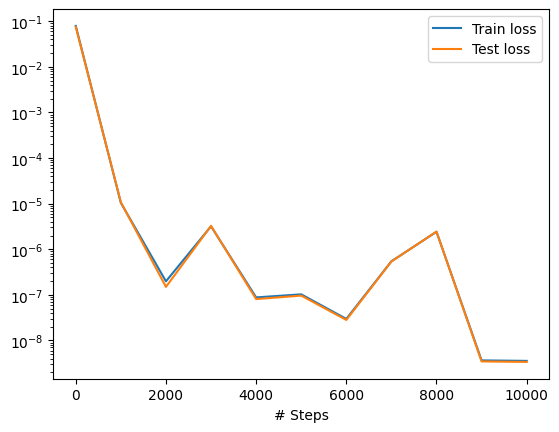

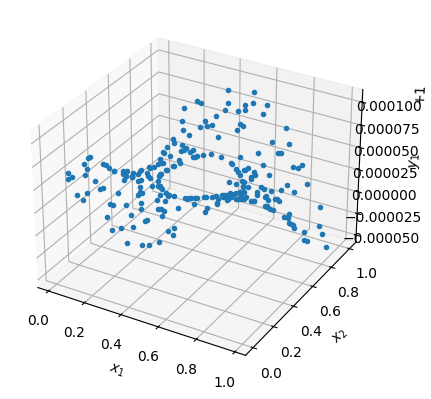

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

D = 1.0
k = 0.1
alpha = 1.0

outer = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])
inclusion = dde.geometry.Disk(center=[0.5, 0.5], radius=0.2)
fluid_domain = outer - inclusion

def robin_func(x, u):
    return -k * (alpha - u)

def boundary_solid(x, on_boundary):
    return on_boundary and inclusion.on_boundary(x)

robin_bc = dde.icbc.RobinBC(
    fluid_domain,
    func=robin_func,
    on_boundary=boundary_solid
)


def pde(x, u):
    d2u_dx2 = dde.grad.hessian(u, x, i=0, j=0)
    d2u_dy2 = dde.grad.hessian(u, x, i=1, j=1)
    return D * (d2u_dx2 + d2u_dy2)  # grad^2(u) = 0

data = dde.data.PDE(
    fluid_domain,
    pde,
    [robin_bc],
    num_domain=1000,
    num_boundary=100,
    solution=None,
    num_test=200,
)

net = dde.nn.FNN(
    [2] + [50] * 4 + [1],
    "tanh",
    "Glorot normal",
)

# 5. Model Compilation
model = dde.Model(data, net)
model.compile("adam", lr=0.001)


losshistory, train_state = model.train(
    iterations=10000,
)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

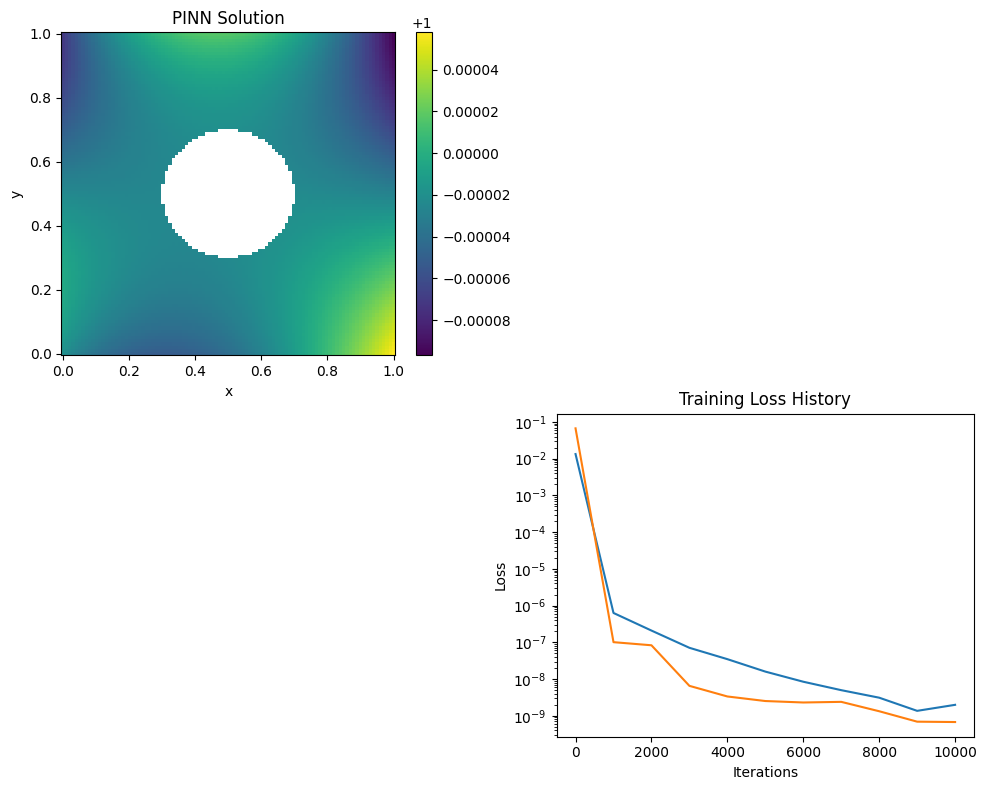

In [ ]:
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
X_flat = X.flatten()[:, None]
Y_flat = Y.flatten()[:, None]
points = np.hstack((X_flat, Y_flat))

Z_pinn = model.predict(points)[:, 0].reshape(X.shape)

mask = (X - 0.5)**2 + (Y - 0.5)**2 <= 0.2**2
Z_pinn[mask] = np.nan

plt.figure(figsize=(10, 8))
plt.subplot(221)
im = plt.pcolormesh(X, Y, Z_pinn, shading='auto', cmap='viridis')
plt.colorbar(im)
plt.title('PINN Solution')
plt.xlabel('x')
plt.ylabel('y')

def fdm_solution(nx, ny, D, k, alpha):
    dx = 1.0 / (nx - 1)
    dy = 1.0 / (ny - 1)

    main_diag = -2 * (1/dx**2 + 1/dy**2) * np.ones(nx*ny)
    off_diag_x = 1/dx**2 * np.ones(nx*ny-1)
    off_diag_y = 1/dy**2 * np.ones(nx*ny-ny)

    A = diags([main_diag, off_diag_x, off_diag_x, off_diag_y, off_diag_y],
              [0, 1, -1, ny, -ny], format='csr')

    b = np.zeros(nx*ny)
    for i in range(nx):
        for j in range(ny):
            idx = i*ny + j
            x, y = i*dx, j*dy
            if (x-0.5)**2 + (y-0.5)**2 <= 0.2**2:
                A[idx, :] = 0
                A[idx, idx] = 1
                b[idx] = 0
            elif (x-0.5)**2 + (y-0.5)**2 <= 0.21**2:  # Boundary approx
                A[idx, idx] -= k/D
                b[idx] = -k*alpha/D

    u = spsolve(A, b)
    return u.reshape((nx, ny))
'''
Z_fdm = fdm_solution(100, 100, D, k, alpha)
Z_fdm[mask] = np.nan

plt.subplot(222)
im = plt.pcolormesh(X, Y, Z_fdm, shading='auto', cmap='viridis')
plt.colorbar(im)
plt.title('FDM Solution')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(223)
diff = Z_pinn - Z_fdm
im = plt.pcolormesh(X, Y, diff, shading='auto', cmap='RdBu', vmin=-0.1, vmax=0.1)
plt.colorbar(im)
plt.title('Difference (PINN - FDM)')
plt.xlabel('x')
plt.ylabel('y')
'''

plt.subplot(224)
plt.semilogy(losshistory.steps, losshistory.loss_train)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss History')

plt.tight_layout()
plt.show()